Giacomo Fidone

email: g.fidone@studenti.unipi.it

# Imports

In [3]:
import os
import sqlite3
import re
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain, combinations

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction import DictVectorizer

# Stile

In [4]:
# specifico lo stile dei grafici

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

# Data Preparation

In [5]:
# importo il dataset

df = pd.read_csv('dataset_ironita_2018.csv')

In [6]:
df.shape

(4849, 6)

In [7]:
df.head()

,twitter_id,text,irony,sarcasm,source,set
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1,0,twita-crowd,test
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1,0,HSC,test
2,577791521174466560,"“@TweetComici: Ogni ragazza: \""non sono una ra...",1,1,twita-crowd,test
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0,0,tw-bs,test
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0,0,HSC,test


In [8]:
# creo un nuovo target multi-label a partire da irony e sarcasm

irony_sarcasm = []
for i, row in df.iterrows():
    if row['irony'] == 0 and row['sarcasm'] == 0:
        irony_sarcasm.append(0)
    elif row['irony'] == 1 and row['sarcasm'] == 0:
        irony_sarcasm.append(1)
    else:
        irony_sarcasm.append(2)
df['irony_sarcasm'] = irony_sarcasm
df = df.drop('sarcasm', axis=1)

In [9]:
df.shape

(4849, 6)

In [10]:
df.head()

,twitter_id,text,irony,source,set,irony_sarcasm
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1,twita-crowd,test,1
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1,HSC,test,1
2,577791521174466560,"“@TweetComici: Ogni ragazza: \""non sono una ra...",1,twita-crowd,test,2
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0,tw-bs,test,0
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0,HSC,test,0


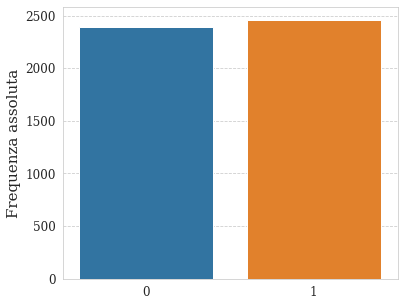

In [11]:
# visualizzo le distribuzioni delle classi target

plt.figure(figsize=(6, 5))
sns.countplot(x='irony', data=df)
plt.xlabel('')
plt.ylabel('Frequenza assoluta')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

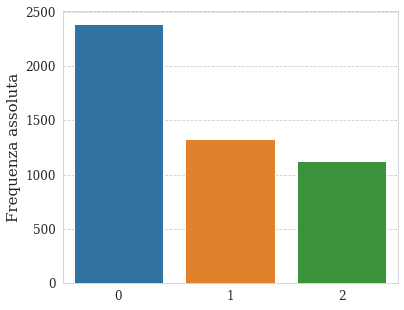

In [12]:
plt.figure(figsize=(6, 5))
sns.countplot(x='irony_sarcasm', data=df)
plt.xlabel('')
plt.ylabel('Frequenza assoluta')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

# Classificazione con profilazione linguistica

### Data Preparation

In [13]:
def generate_files(df, column, out_dir):
    
    '''Genera un file di testo per ogni valore di column in df e lo salva in out_dir
    tenendo traccia dell'indice di riga'''
    
    os.mkdir(out_dir)
    for index, row in df.iterrows():
        out_file_name = f'{index}.txt' 
        out_file_path = os.path.join(out_dir, out_file_name)
        with open(out_file_path, 'w') as out_file:
            out_file.write(row[column])
            out_file.write('\n')

In [ ]:
# genero i file da passare a Profiling-UD

generate_files(df, 'text', 'profiling_input')

In [14]:
# importo il file csv restituito in output da Profiling-UD

profiling_output = pd.read_csv('/Users/Giacomo/Desktop/folder_LC_project/profiling_output.csv', sep='\t')

In [15]:
profiling_output.shape

(4849, 134)

In [16]:
profiling_output.head()

,Filename,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,...,principal_proposition_dist,subordinate_proposition_dist,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5
0,profiling_input/2448.conllu,1,15,15.0,6.400000,13.333333,0.000000,6.666667,0.0,0.000000,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,profiling_input/1843.conllu,2,23,11.5,6.500000,13.043478,8.695652,13.043478,0.0,4.347826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,profiling_input/2976.conllu,2,20,10.0,6.000000,5.000000,15.000000,5.000000,5.0,5.000000,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,profiling_input/4146.conllu,1,8,8.0,5.714286,12.500000,0.000000,12.500000,12.5,0.000000,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,profiling_input/2419.conllu,3,24,8.0,5.200000,4.166667,12.500000,0.000000,0.0,4.166667,...,50.0,50.0,0.0,100.0,1.0,100.0,0.0,0.0,0.0,0.0


In [17]:
# recupero dall'indice in Filename l'informazione relativa ai target (irony, irony_sarcasm) e allo split

irony_list = []
irony_sarcasm_list = []
split_list = []

for i, row in profiling_output.iterrows():
    filename = row['Filename']
    index = int(re.findall(r"(\d+)", filename)[0]) 
    irony = df.iloc[index]['irony']
    irony_sarcasm = df.iloc[index]['irony_sarcasm']
    split = df.iloc[index]['set']
    irony_list.append(irony)
    irony_sarcasm_list.append(irony_sarcasm)
    split_list.append(split)

profiling_output['irony'] = irony_list
profiling_output['irony_sarcasm'] = irony_sarcasm_list
profiling_output['set'] = split_list

In [18]:
profiling_output.shape

(4849, 137)

In [19]:
profiling_output.head()

,Filename,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,...,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5,irony,irony_sarcasm,set
0,profiling_input/2448.conllu,1,15,15.0,6.400000,13.333333,0.000000,6.666667,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,training
1,profiling_input/1843.conllu,2,23,11.5,6.500000,13.043478,8.695652,13.043478,0.0,4.347826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,training
2,profiling_input/2976.conllu,2,20,10.0,6.000000,5.000000,15.000000,5.000000,5.0,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,training
3,profiling_input/4146.conllu,1,8,8.0,5.714286,12.500000,0.000000,12.500000,12.5,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,training
4,profiling_input/2419.conllu,3,24,8.0,5.200000,4.166667,12.500000,0.000000,0.0,4.166667,...,100.0,1.0,100.0,0.0,0.0,0.0,0.0,0,0,training


In [20]:
# elimino Filename

profiling_output = profiling_output.drop('Filename', axis=1)

In [21]:
profiling_output.shape

(4849, 136)

In [22]:
profiling_output.head()

,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,upos_dist_DET,...,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5,irony,irony_sarcasm,set
0,1,15,15.0,6.400000,13.333333,0.000000,6.666667,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,training
1,2,23,11.5,6.500000,13.043478,8.695652,13.043478,0.0,4.347826,8.695652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,training
2,2,20,10.0,6.000000,5.000000,15.000000,5.000000,5.0,5.000000,15.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,training
3,1,8,8.0,5.714286,12.500000,0.000000,12.500000,12.5,0.000000,25.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,training
4,3,24,8.0,5.200000,4.166667,12.500000,0.000000,0.0,4.166667,8.333333,...,100.0,1.0,100.0,0.0,0.0,0.0,0.0,0,0,training


In [23]:
# separo train e test

df_train = profiling_output[profiling_output['set'] == 'training'].drop('set', axis=1)
df_test = profiling_output[profiling_output['set'] == 'test'].drop('set', axis=1)

In [24]:
# resetto l'indice

df_train = df_train.reset_index().drop('index', axis=1)
df_test = df_test.reset_index().drop('index', axis=1)

In [25]:
print(df_train.shape, df_test.shape)

(3977, 135) (872, 135)


In [26]:
df_train.head()

,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,upos_dist_DET,...,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5,irony,irony_sarcasm
0,1,15,15.0,6.400000,13.333333,0.000000,6.666667,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2,23,11.5,6.500000,13.043478,8.695652,13.043478,0.0,4.347826,8.695652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2,20,10.0,6.000000,5.000000,15.000000,5.000000,5.0,5.000000,15.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,1,8,8.0,5.714286,12.500000,0.000000,12.500000,12.5,0.000000,25.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
4,3,24,8.0,5.200000,4.166667,12.500000,0.000000,0.0,4.166667,8.333333,...,0.0,100.0,1.0,100.0,0.0,0.0,0.0,0.0,0,0


In [27]:
df_test.head()

,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,upos_dist_DET,...,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3,subordinate_dist_4,subordinate_dist_5,irony,irony_sarcasm
0,2,20,10.0,4.647059,0.000000,0.000000,20.000000,5.000000,5.000000,10.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,19,19.0,6.588235,5.263158,31.578947,0.000000,5.263158,0.000000,0.000000,...,100.0,0.0,1.0,100.0,0.0,0.0,0.0,0.0,0,0
2,2,17,8.5,4.466667,5.882353,5.882353,17.647059,0.000000,0.000000,11.764706,...,0.0,100.0,1.0,100.0,0.0,0.0,0.0,0.0,1,2
3,1,17,17.0,6.823529,11.764706,23.529412,5.882353,0.000000,5.882353,0.000000,...,0.0,100.0,1.0,100.0,0.0,0.0,0.0,0.0,0,0
4,3,21,7.0,6.705882,4.761905,4.761905,9.523810,4.761905,0.000000,4.761905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2


### Classificazione binaria di irony

In [28]:
# inizializzo X, y

X_train = df_train.drop(['irony', 'irony_sarcasm'], axis=1)
y_train = df_train['irony'].to_numpy()
X_test = df_test.drop(['irony', 'irony_sarcasm'], axis=1)
y_test = df_test['irony'].to_numpy()

In [29]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3977, 133) (3977,)
(872, 133) (872,)


In [30]:
# normalizzo X_train, X_test

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [31]:
print(X_train.shape, X_test.shape)

(3977, 133) (872, 133)


In [32]:
def randomized_search_svm(X_train, y_train, scoring='accuracy'):
    
    '''Prende in input X_train, y_train ed esegue una randomized search sugli iper-parametri di SVM. 
    Restituisce best_score_ e best_estimator_.'''
    
    param_grid = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
              'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'class_weight': ['balanced', None]
             }

    search = RandomizedSearchCV(SVC(max_iter=1e6), 
                      param_grid, 
                      cv=StratifiedKFold(3, shuffle=True, random_state=42),
                      n_iter=50,
                      scoring=scoring,
                      n_jobs=-1)

    search.fit(X_train, y_train)
    print(f'Best score: {search.best_score_}, Best estimator: {search.best_estimator_}')

In [33]:
# definisco una funzione per implementare una KFold CV

def KFold_CV(n_folds, model, X, y, baseline_strategy='most_frequent'):
    
    '''Implementa una KFold_CV di model e di una baseline su X, y. Restituisce dizionario con media e incertezza di 
    Accuracy ed F1-Macro sugli n_folds di model e di baseline.'''
    
    results = dict()
    folds = KFold(n_folds, shuffle=True, random_state=42)

    accs_svm = list()
    f1s_svm = list()
    accs_dummy = list()
    f1s_dummy = list()

    for train_ids, test_ids in folds.split(X):
        fold_X_train = X[train_ids]
        fold_y_train = y[train_ids]

        fold_X_test = X[test_ids]
        fold_y_test = y[test_ids]
    
        dummy = DummyClassifier(strategy=baseline_strategy) # default baseline-mfc
        dummy.fit(fold_X_train, fold_y_train)
        fold_y_pred = dummy.predict(fold_X_test)
        accuracy = accuracy_score(fold_y_test, fold_y_pred)
        f1_macro = f1_score(fold_y_test, fold_y_pred, average='macro')
        accs_dummy.append(accuracy)
        f1s_dummy.append(f1_macro)

        model.fit(fold_X_train, fold_y_train)
        fold_y_pred = model.predict(fold_X_test)
        accuracy = accuracy_score(fold_y_test, fold_y_pred)
        f1_macro = f1_score(fold_y_test, fold_y_pred, average='macro')
        accs_svm.append(accuracy)
        f1s_svm.append(f1_macro)
    
    results['Avg Accuracy Baseline'] = (np.mean(accs_dummy), np.std(accs_dummy))
    results['Avg F1-Macro baseline'] = (np.mean(f1s_dummy), np.std(f1s_dummy))
    results['Avg Accuracy Model'] = (np.mean(accs_svm), np.std(accs_svm))
    results['Avg F1-Macro Model'] = (np.mean(f1s_svm), np.std(f1s_svm))
    
    return results

In [35]:
# effettuo randomized search su X_train, y_train

randomized_search_svm(X_train, y_train)

Best score: 0.6658275230750259, Best estimator: SVC(class_weight='balanced', gamma=1000.0, kernel='linear', max_iter=1000000.0)


In [37]:
# inizializzo e traino il best estimator

clf = SVC(kernel='linear', gamma=1e3, class_weight='balanced', max_iter=1e6)
clf.fit(X_train, y_train)

SVC(class_weight='balanced', gamma=1000.0, kernel='linear', max_iter=1000000.0)

In [38]:
# valuto il best estimator su train con 5-Fold CV

KFold_CV(5, clf, X_train, y_train)

{'Avg Accuracy Baseline': (0.5086666034575392, 0.014134964279642106),
 'Avg F1-Macro baseline': (0.33710490543954735, 0.006203907648926391),
 'Avg Accuracy Model': (0.6605477070889036, 0.008089593445442442),
 'Avg F1-Macro Model': (0.6591851979662672, 0.008492997800972377)}

In [39]:
# valuto il best estimator su hold-out test

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65       437
           1       0.65      0.71      0.68       435

    accuracy                           0.67       872
   macro avg       0.67      0.67      0.67       872
weighted avg       0.67      0.67      0.67       872



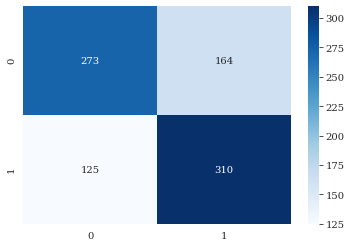

In [40]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

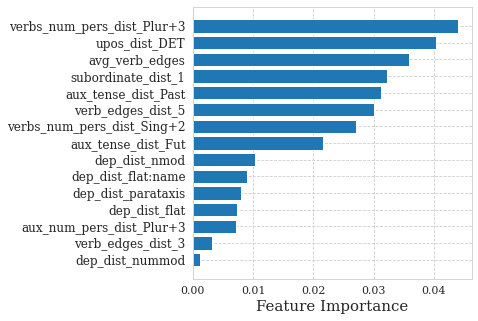

In [41]:
# visualizzo le prime 15 variabili con la più alta feature importance

train_columns = [column for column in profiling_output.drop(['irony', 'irony_sarcasm', 'set'], axis=1)]
features_names = train_columns[1:]
idx = 0
coefs = np.abs(clf.coef_[idx])
feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))
num_to_plot = 15
plt.figure(figsize=(5, 5))
plt.yticks(fontsize=12)
plt.xticks(fontsize=11)
plt.xlabel('Feature Importance')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()

### Classificazione multi-classe di irony_sarcasm

In [42]:
# inizializzo X, y

X_train = df_train.drop(['irony', 'irony_sarcasm'], axis=1)
y_train = df_train['irony_sarcasm'].to_numpy()
X_test = df_test.drop(['irony', 'irony_sarcasm'], axis=1)
y_test = df_test['irony_sarcasm'].to_numpy()

In [43]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3977, 133) (3977,)
(872, 133) (872,)


In [44]:
# normalizzo X_train, X_test

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [45]:
print(X_train.shape, X_test.shape)

(3977, 133) (872, 133)


In [ ]:
# effettuo randomized search su X_train, y_train

randomized_search_svm(X_train, y_train, scoring='f1_macro')

In [48]:
# inizializzo e traino il best estimator

clf = SVC(kernel='linear', gamma=1e-4, max_iter=1e6)
clf.fit(X_train, y_train)

SVC(gamma=0.0001, kernel='linear', max_iter=1000000.0)

In [49]:
# valuto il best estimator su train con 5-Fold CV

KFold_CV(5, clf, X_train, y_train)

{'Avg Accuracy Baseline': (0.4913333965424608, 0.014134964279642106),
 'Avg F1-Macro baseline': (0.21959920720225262, 0.004242458302661342),
 'Avg Accuracy Model': (0.5230131791030626, 0.01816205285435545),
 'Avg F1-Macro Model': (0.40011863466580727, 0.01304098920951403)}

In [50]:
# valuto il best estimator su hold-out test

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       437
           1       0.34      0.43      0.38       219
           2       0.39      0.07      0.12       216

    accuracy                           0.51       872
   macro avg       0.44      0.42      0.39       872
weighted avg       0.48      0.51      0.46       872



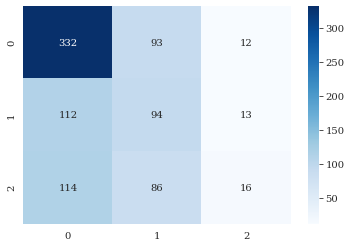

In [51]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

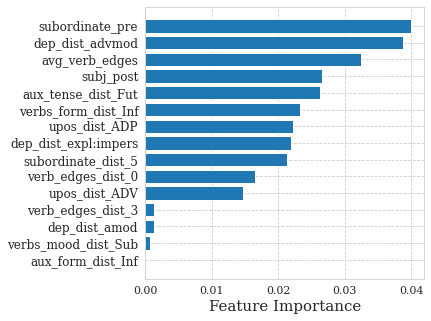

In [52]:
# visualizzo le prime 15 variabili con la più alta feature importance

train_columns = [column for column in profiling_output.drop(['irony', 'irony_sarcasm', 'set'], axis=1)]
features_names = train_columns[1:]
idx = 0
coefs = np.abs(clf.coef_[idx])
feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))
num_to_plot = 15
plt.figure(figsize=(5, 5))
plt.yticks(fontsize=12)
plt.xticks([0, 0.01, 0.02, 0.03, 0.04], fontsize=11)
plt.xlabel('Feature Importance')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()

# Classificazione con informazione lessicale

### Data Preparation

In [53]:
def load_files(conllu_dir):
    
    '''Prende in input la directory con i file e li
    restituisce in una lista'''
    
    files = []
    for file_name in os.listdir(conllu_dir):
        file_path = os.path.join(conllu_dir, file_name)
        files.append(file_path)
    return files

In [54]:
# carico i file dalla directory che contiene le annotazioni

files = load_files('annotation_output')

In [55]:
# separo train files e test files

train_files = []
test_files = []


for file in files:
    index = int(re.findall(r"(\d+)", file)[0]) # recupero l'indice dal nome del file
    split = df.iloc[index]['set'] # recupero il valore corrispondente di 'set' da df
    if split == 'training':
        train_files.append(file)
    else:
        test_files.append(file)

In [56]:
print(len(train_files))
print(len(test_files))

3977
872


### Definizione di metodi per l'estrazione delle features

In [57]:
def get_sentences_from_file(src_path):
    
    ''' Prende in input il path di un file con annotazione linguistica e restituisce una lista
    con le frasi del testo. Ciascuna frase è rappresentata con una lista di dizionari (parole).'''
    
    post_sentences = []               
    sentence = []                      
    for line in open(src_path, 'r'):
        if line[0].isdigit():          
            splitted_line = line.strip().split('\t')
            if '-' not in splitted_line[0]:  
                token = {
                    'word': splitted_line[1],
                    'lemma': splitted_line[2],
                    'pos': splitted_line[3]
                }
                sentence.append(token)
        if line == '\n':  
            post_sentences.append(sentence)
            sentence = []
    return post_sentences

In [58]:
def extract_word_ngrams(word_ngrams, sentence, el, n):
    
    '''Prende in input una frase e restituisce n-grammi di parole'''
    
    all_words = [] # creo una lista con tutte le parole
    for token in sentence:
        all_words.append(token[el])
   
    for i in range(0, len(all_words) - n + 1): # estraggo gli n-grammi
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1
    
    return word_ngrams

In [59]:
def extract_char_ngrams(char_ngrams, sentence, n):
    
    '''Prende in input una frase e restituisce n-grammi di caratteri'''
    
    all_words = []
    for token in sentence:
        all_words.append(token['word'])

    all_words = ' '.join(all_words)
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1
    
    return char_ngrams

In [60]:
# definisco funzioni per la normalizzazione degli n-grammi

def count_post_words(post):
    
    '''Restituisce il numero di parole di un post'''
    
    num_words = 0
    for sentence in post:
        num_words += len(sentence)
    return num_words


def count_post_chars(post):
    
    '''Restituisce il numero di caratteri di un post'''
    
    num_chars = 0
    for sentence in post:
        for token in sentence:
            num_chars += len(token['word'])
        num_chars += len(sentence) - 1  # includo gli spazi nel conteggio
    return num_chars

def normalize_ngrams(ngrams_dict, post_len):
    
    '''Normalizza gli n-grammi di una frase rispetto alla lunghezza del post'''
    
    for key in ngrams_dict:
        ngrams_dict[key] = ngrams_dict[key]/float(post_len)

In [61]:
def extract_features_from_word_ngrams(dataset, e, n):
    
    '''Estrae features da n-grammi di parole'''
    
    dataset_features = []
    for post in dataset:
        word_ngrams = dict()
        for sentence in post:
            extract_word_ngrams(word_ngrams, sentence, e, n)
        num_words = count_post_words(post)
        normalize_ngrams(word_ngrams, num_words)
        dataset_features.append(word_ngrams)
    return dataset_features

In [62]:
def extract_features_from_char_ngrams(dataset, n):
    
    '''Estrae features da n-grammi di caratteri'''
    
    dataset_features = []
    for post in dataset:
        char_ngrams = dict()
        for sentence in post:
            extract_char_ngrams(char_ngrams, sentence, n)
        num_chars = count_post_chars(post)
        normalize_ngrams(char_ngrams, num_chars)
        dataset_features.append(char_ngrams)
    return dataset_features

In [63]:
def get_num_features(dataset):
    
    '''Restituisce il numero di features del dataset'''

    all_features = set()
    for post_dict in dataset:
        all_features.update(list(post_dict.keys()))
    return len(all_features)

In [64]:
def filter_features(features, min_occurrences):
    
    '''Restituisce train_features che occorrono almeno min_occurrences'''
    
    features_counter = dict()
    for post_dict in features:
        for feature in post_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    for post_dict in features:
        post_features = list(post_dict.keys())
        for feature in post_features:
            if features_counter[feature] < min_occurrences:
                post_dict.pop(feature)
                
    return features

In [65]:
def generate_y(files, target_name):
    
    '''Prende in input i file con annotazione e restituisce le labels corrispondenti
    di un target prescelto'''
    
    labels = []
    for file in files:
        index = int(re.findall(r"(\d+)", file)[0]) # recupero l'indice dal nome del file
        label = df.iloc[index][target_name] 
        labels.append(label)
    return np.array(labels)

###  Valutazione di diverse configurazioni di n-grammi con K-Fold CV (TR) per irony

In [66]:
def extract_features(dataset, n, combinations):
    
    '''Genera un dataset di features a partire da diverse combinazioni di n-grammi'''
    
    dataset_features = []
    for document in dataset:
        num_words = count_post_words(document) 
        num_chars = count_post_chars(document)
        document_features = []
        for sentence in document:
            for e in combinations:
                if e == 'char':
                    feature = extract_char_ngrams(dict(), sentence, n)
                    normalize_ngrams(feature, num_chars)
                    document_features.append(feature)
                else:
                    feature = extract_word_ngrams(dict(), sentence, e, n)
                    normalize_ngrams(feature, num_words)
                    document_features.append(feature)
        user_features = dict()
        for ngrams_dict in document_features:
            for ngram in ngrams_dict:
                user_features[ngram] = ngrams_dict[ngram]
        dataset_features.append(user_features)
    return dataset_features 

In [67]:
# genero il train dataset 

train_dataset = []

for post_path in train_files:
    post_sentences = get_sentences_from_file(post_path)
    train_dataset.append(post_sentences)

In [68]:
# genero il test dataset

test_dataset = []

for file_path in test_files:
    doc_sentences = get_sentences_from_file(file_path)
    test_dataset.append(doc_sentences)

In [70]:
def powerset(s):
    
    '''Restituisce il powerset di un array s escluso il set vuoto'''
    
    powerset = list()
    x = len(s)
    for i in range(1, 1 << x):
        item = [s[j] for j in range(x) if (i & (1 << j))]
        powerset.append(item)
    return powerset

In [71]:
# genero un dizionario (results) con la media di F1-Macro su 5-Fold CV di SVM lineare per ogni combinazione di n-grammi

elements = ['word', 'lemma', 'pos', 'char']
combinations = powerset(elements)
results = dict()
for n in range(1, 5): 
    for combination in combinations:
        
        # genero le train features
        train_features = extract_features(train_dataset, n, combination)
        train_features = filter_features(train_features, 5)
        
        # genero X_train, y_train
        vectorizer = DictVectorizer() # trasformazione in matrice sparsa
        X_train = vectorizer.fit_transform(train_features)
        scaler = MaxAbsScaler() # normalizzazione
        X_train = scaler.fit_transform(X_train)
        y_train = generate_y(train_files, 'irony')
        
        # traino LinearSVC
        clf = LinearSVC(max_iter=1e4)
        
        # valuto con KFold su X_train, y_train
        kfold_results = KFold_CV(5, clf, X_train, y_train)
        avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
        
        
        # salvo in results
        key = f"{n}-grammi di {', '.join(combination)}"
        results[key] = avg_f1_macro

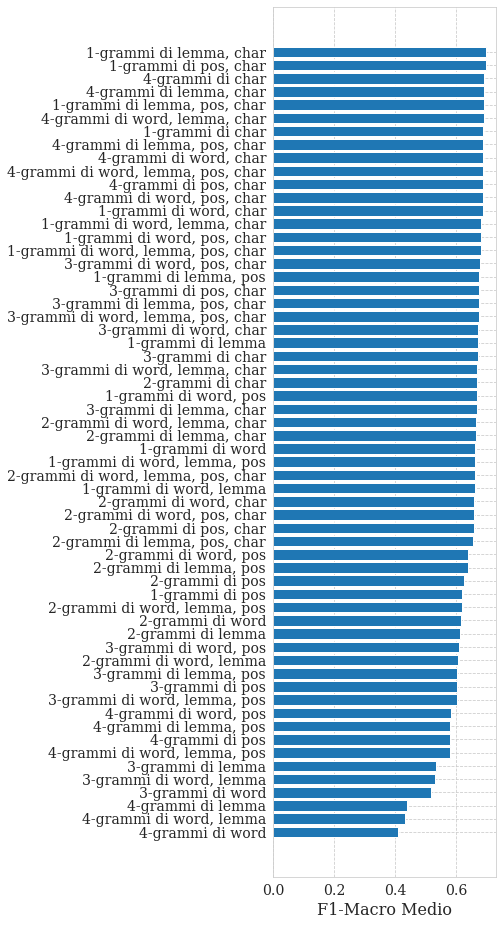

In [79]:
# visualizzo gli F1-Macro medi di ciascuna combinazione di n-grammi 

sorted_data = sorted(results.items(), key=lambda x: x[1], reverse=False)
key, values = zip(*sorted_data)

plt.figure(figsize=(4, 16))
plt.barh(key, values)
plt.xlabel('F1-Macro Medio', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Classificazione binaria di irony

In [80]:
# ridefinisco extract_features per includere solo le features più importanti nel feature set

def extract_features(dataset):
    
    '''Genera un dataset di features a partire da diverse combinazioni di n-grammi'''
    
    dataset_features = []
    for document in dataset:
        lemma_unigrams = dict()
        char_unigrams = dict()
        char_quadrigrams = dict()
        lemma_quadrigrams = dict()
        for sentence in document:
            extract_word_ngrams(lemma_unigrams, sentence, 'lemma', 1)
            extract_char_ngrams(char_unigrams, sentence, 1)
            extract_char_ngrams(char_quadrigrams, sentence, 4)
            extract_word_ngrams(lemma_quadrigrams, sentence, 'lemma', 4)

        num_words = count_post_words(document)
        num_chars = count_post_chars(document)
        normalize_ngrams(lemma_unigrams, num_words)
        normalize_ngrams(char_unigrams, num_chars)
        normalize_ngrams(char_quadrigrams, num_chars)
        normalize_ngrams(lemma_quadrigrams, num_words)
        
        user_features = dict()
        for ngrams_dict in [lemma_unigrams, char_unigrams, char_quadrigrams, lemma_quadrigrams]:
            for ngram in ngrams_dict:
                user_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(user_features)
    return dataset_features

In [81]:
# genero il train dataset 

train_dataset = []

for post_path in train_files:
    post_sentences = get_sentences_from_file(post_path)
    train_dataset.append(post_sentences)

In [82]:
# estraggo le train features

train_features = extract_features(train_dataset)
get_num_features(train_features)

126335

In [83]:
# filtro le features meno importanti

train_features = filter_features(train_features, 5)
get_num_features(train_features)

12689

In [84]:
# genero X_train, y_train

vectorizer = DictVectorizer() # trasformazione in matrice sparsa
X_train = vectorizer.fit_transform(train_features)

scaler = MaxAbsScaler() # normalizzazione
X_train = scaler.fit_transform(X_train)

y_train = generate_y(train_files, 'irony')

In [85]:
# genero il test dataset

test_dataset = []

for file_path in test_files:
    doc_sentences = get_sentences_from_file(file_path)
    test_dataset.append(doc_sentences)

In [86]:
# genero X_test, y_test

test_features = extract_features(test_dataset)
X_test = vectorizer.transform(test_features)
X_test = scaler.transform(X_test)
y_test = generate_y(test_files, 'irony')

In [87]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3977, 12689) (3977,)
(872, 12689) (872,)


In [89]:
# effettuo randomized search su X_train, y_train

randomized_search_svm(X_train, y_train)

Best score: 0.7394995114639954, Best estimator: SVC(C=100.0, gamma=0.0001, max_iter=1000000.0)


In [91]:
# inizializzo e traino il best estimator

clf = SVC(kernel='rbf', gamma=1e-4, C=1e2, max_iter=1e6)
clf.fit(X_train, y_train)

SVC(C=100.0, gamma=0.0001, max_iter=1000000.0)

In [92]:
# valuto il best estimator su train con 5-Fold CV

KFold_CV(5, clf, X_train, y_train)

{'Avg Accuracy Baseline': (0.5086760848266489, 0.018663369136801927),
 'Avg F1-Macro baseline': (0.3370654255475562, 0.008227033324035762),
 'Avg Accuracy Model': (0.7377405897411585, 0.006643097057100394),
 'Avg F1-Macro Model': (0.7359908521516713, 0.007136169086907847)}

In [93]:
# valuto il best estimator su hold-out test

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67       437
           1       0.67      0.82      0.74       435

    accuracy                           0.71       872
   macro avg       0.72      0.71      0.70       872
weighted avg       0.72      0.71      0.70       872



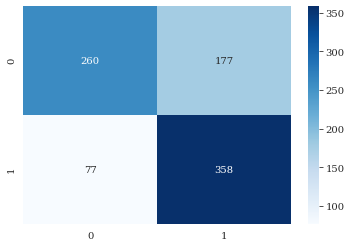

In [94]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

### Valutazione di diverse configurazioni di n-grammi con K-Fold CV (TR) per irony_sarcasm

In [95]:
def extract_features(dataset, n, combinations):
    
    '''Genera un dataset di features a partire da diverse combinazioni di n-grammi'''
    
    dataset_features = []
    for document in dataset:
        num_words = count_post_words(document) 
        num_chars = count_post_chars(document)
        document_features = []
        for sentence in document:
            for e in combinations:
                if e == 'char':
                    feature = extract_char_ngrams(dict(), sentence, n)
                    normalize_ngrams(feature, num_chars)
                    document_features.append(feature)
                else:
                    feature = extract_word_ngrams(dict(), sentence, e, n)
                    normalize_ngrams(feature, num_words)
                    document_features.append(feature)
        user_features = dict()
        for ngrams_dict in document_features:
            for ngram in ngrams_dict:
                user_features[ngram] = ngrams_dict[ngram]
        dataset_features.append(user_features)
    return dataset_features 

In [96]:
# genero un dizionario (results) con la media di F1-Macro su 5-Fold CV di SVM lineare per ogni combinazione di n-grammi

elements = ['word', 'lemma', 'pos', 'char']
combinations = powerset(elements)
results = dict()
for n in range(1, 5): 
    for combination in combinations:
        
        # genero le train features
        train_features = extract_features(train_dataset, n, combination)
        train_features = filter_features(train_features, 5)
        
        # genero X_train, y_train
        vectorizer = DictVectorizer() # trasformazione in matrice sparsa
        X_train = vectorizer.fit_transform(train_features)
        scaler = MaxAbsScaler() # normalizzazione
        X_train = scaler.fit_transform(X_train)
        y_train = generate_y(train_files, 'irony_sarcasm')
        
        # traino LinearSVC
        clf = LinearSVC(max_iter=1e4)
        
        # valuto con KFold su X_train, y_train
        kfold_results = KFold_CV(5, clf, X_train, y_train)
        avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
        
        
        # salvo in results
        key = f"{n}-grammi di {', '.join(combination)}"
        results[key] = avg_f1_macro

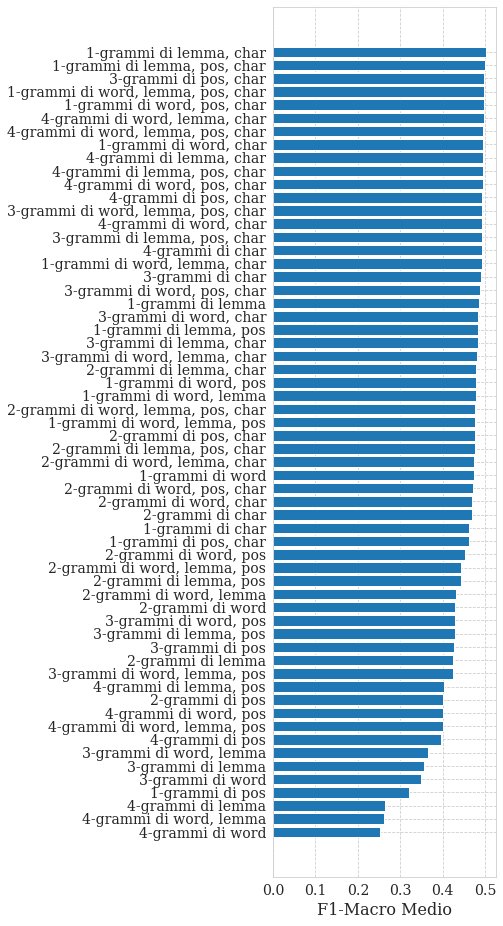

In [97]:
# visualizzo gli F1-Macro medi di ciascuna combinazione di n-grammi 

sorted_data = sorted(results.items(), key=lambda x: x[1], reverse=False)
key, values = zip(*sorted_data)

plt.figure(figsize=(4, 16))
plt.barh(key, values)
plt.xlabel('F1-Macro Medio', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Classificazione multi-classe di irony_sarcasm

In [98]:
# ridefinisco extract_features per includere solo le features più importanti nel feature set

def extract_features(dataset):
    dataset_features = []
    for document in dataset:
        lemma_unigrams = dict()
        char_unigrams = dict()
        pos_trigrams = dict()
        char_trigrams = dict()
        for sentence in document:
            extract_word_ngrams(lemma_unigrams, sentence, 'lemma', 1)
            extract_char_ngrams(char_unigrams, sentence, 1)
            extract_word_ngrams(pos_trigrams, sentence, 'pos', 3)
            extract_char_ngrams(char_trigrams, sentence, 3)

        num_words = count_post_words(document)
        num_chars = count_post_chars(document)
        normalize_ngrams(lemma_unigrams, num_words)
        normalize_ngrams(char_unigrams, num_chars)
        normalize_ngrams(pos_trigrams, num_chars)
        normalize_ngrams(char_trigrams, num_words)
        
        user_features = dict()
        for ngrams_dict in [lemma_unigrams, char_unigrams, pos_trigrams, char_trigrams]:
            for ngram in ngrams_dict:
                user_features[ngram] = ngrams_dict[ngram]

        dataset_features.append(user_features)
    return dataset_features

In [99]:
# estraggo le train features

train_features = extract_features(train_dataset)
get_num_features(train_features)

43029

In [100]:
# filtro le features meno importanti

train_features = filter_features(train_features, 5)
get_num_features(train_features)

7667

In [101]:
# genero X_train, y_train

vectorizer = DictVectorizer() # trasformazione in matrice sparsa
X_train = vectorizer.fit_transform(train_features)

scaler = MaxAbsScaler() # normalizzazione
X_train = scaler.fit_transform(X_train)

y_train = generate_y(train_files, 'irony_sarcasm')

In [102]:
# genero X_test, y_test

test_features = extract_features(test_dataset)
X_test = vectorizer.transform(test_features)
X_test = scaler.transform(X_test)
y_test = generate_y(test_files, 'irony_sarcasm')

In [103]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3977, 7667) (3977,)
(872, 7667) (872,)


In [ ]:
# effettuo randomized search su X_train, y_train

randomized_search_svm(X_train, y_train, scoring='f1_macro')

In [106]:
# inizializzo e traino il best estimator

clf = SVC(C=1e-2, class_weight='balanced', gamma=10, kernel='linear', max_iter=1e6)
clf.fit(X_train, y_train)

SVC(C=0.01, class_weight='balanced', gamma=10, kernel='linear',
    max_iter=1000000.0)

In [107]:
# valuto il best estimator su train con 5-Fold CV

KFold_CV(5, clf, X_train, y_train)

{'Avg Accuracy Baseline': (0.491323915173351, 0.018663369136801927),
 'Avg F1-Macro baseline': (0.21956676218045118, 0.0055787042809031274),
 'Avg Accuracy Model': (0.5539385607281692, 0.008281066933213278),
 'Avg F1-Macro Model': (0.5336889698354507, 0.0073610727223876096)}

In [108]:
# valuto il best estimator su hold-out test

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.52      0.63       437
           1       0.34      0.47      0.40       219
           2       0.38      0.48      0.42       216

    accuracy                           0.50       872
   macro avg       0.50      0.49      0.48       872
weighted avg       0.57      0.50      0.52       872



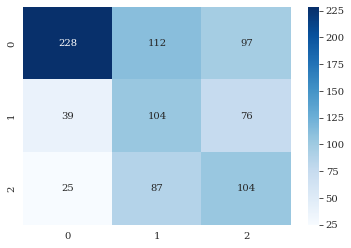

In [109]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# Classificazione con Word Embeddings

### Data Preparation

In [ ]:
# converto il file sql in un file txt

con = sqlite3.connect(sql_path)
cur = con.cursor()

sql_path = f'itwac32_clitics.sqlite'
txt_path = f'itwac32_clitics.txt'

with open(txt_path, 'w+') as out_file:
    for embedding in cur.execute("SELECT * FROM store"):
        str_embedding = [str(el) for el in embedding[:-1]]
        out_file.write('\t'.join(str_embedding)+'\n')
out_file.close()

In [110]:
def load_word_embeddings(src_path):
    
    '''Prende in input il file txt con word embeddings e restituisce un dizionario
    della forma: {parola : embedding}'''
    
    embeddings = dict()
    for line in open(src_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] 
        embeddings[word] = np.asarray(embedding) 
    return embeddings

In [111]:
# converto i WE

we = load_word_embeddings(txt_path)

In [112]:
# definisco una funzione per la gestione dei digits

def get_digits(text):
    try:
        val = int(text)
    except:
        text = re.sub('\d', '@Dg', text)
        return text
    if val >= 0 and val < 2100:
        return str(val)
    else:
        return "DIGLEN_" + str(len(str(val)))

In [113]:
# definisco una funzione per la normalizzazione delle parole

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

In [114]:
def get_tokens_from_file(src_path):
    
    '''Prende in input il path di un testo txt e restituisce un dizionario con forma e pos.'''
    
    user_tokens = []
    lines_to_skip = 0
    take_pos = False
    
    for line in open(src_path, 'r'):
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                skip_ids = splitted_line[0].split('-')
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # indica che bisogna prendere la pos della parola che segue
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = {
                    'word': word,
                    'pos': pos
                }
                user_tokens.append(token)
            else:
                if lines_to_skip == 0:
                    
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    user_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    user_tokens[-1]['pos'] = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return user_tokens

In [115]:
# inizializzo il train_dataset

train_dataset = []

for user_path in train_files:
    user_sentences = get_tokens_from_file(user_path)
    train_dataset.append(user_sentences)

In [116]:
# inizializzo il test_dataset

test_dataset = []

for user_path in test_files:
    user_sentences = get_tokens_from_file(user_path)
    test_dataset.append(user_sentences)

In [117]:
print(len(train_dataset))
print(len(test_dataset))

3977
872


In [118]:
def compute_embeddings_mean(user_embeddings):
    
    '''Calcola la media di un set di embeddings in input'''
    
    sum_array = np.sum(user_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(user_embeddings))
    return mean_array

In [119]:
# definisco una funzione che calcola la media di tutti gli embeddings

def compute_all_embeddings_mean(user_tokens, embeddings, embeddings_dim):
    
    '''Calcola la media degli embeddings di un user'''
    
    user_embeddings = []
    for token in user_tokens:
        word = token['word']
        if word in embeddings:
            user_embeddings.append(embeddings[word])
    
    if len(user_embeddings) == 0:
        user_embeddings = [np.zeros(embeddings_dim)]
    
    user_embeddings = compute_embeddings_mean(user_embeddings)
    return user_embeddings

In [120]:
def compute_filtered_embeddings_mean(user_tokens, embeddings, embeddings_dim, pos_filter):
    
    '''Calcola la media degli embeddings di un user ma solo delle parole la cui pos è in pos_filter'''
    
    user_embeddings = []
    
    for token in user_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in pos_filter:
            user_embeddings.append(embeddings[word])
    
    if len(user_embeddings) == 0:
        user_embeddings = [np.zeros(embeddings_dim)]
    
    user_embeddings = compute_embeddings_mean(user_embeddings)
    return user_embeddings

In [121]:
def compute_filtered_embeddings_sep_means(user_tokens, embeddings, embeddings_dim, pos_filter):
    
    '''Calcola la concatenazione delle medie degli embeddings di un user per ciascun pos in pos_filter'''
    
    user_pos_embeddings_means = list()
    unique_pos = np.unique([token['pos'] for token in user_tokens])

    for pos in pos_filter:
        pos_embeddings = list()
        for token in user_tokens:
            if token['word'] in embeddings and token['pos'] == pos:
                    pos_embeddings.append(embeddings[token['word']])
        if len(pos_embeddings) == 0:
            pos_embeddings.append(np.zeros(embeddings_dim))
            
        pos_embeddings_mean = compute_embeddings_mean(pos_embeddings)
        user_pos_embeddings_means.append(pos_embeddings_mean)
    
    user_pos_embeddings_concat = list()
    for mean in user_pos_embeddings_means:
        user_pos_embeddings_concat.extend(mean)
        
    return np.array(user_pos_embeddings_concat)

In [122]:
# definisco una funzione per l'estrazione delle features

def extract_features(dataset, embeddings, embeddings_dim, aggregation='mean', pos_filter=None):
    
    '''Estrae le feature dal dataset a seconda della strategia di aggregation prescelta (mean, filtered
    mean, concatenated_means)'''
    
    dataset_features = list()
    for user_tokens in dataset:
        if aggregation == 'mean':
            user_embeddings = compute_all_embeddings_mean(user_tokens, embeddings, embeddings_dim)
        elif aggregation == 'filtered_mean':
            user_embeddings = compute_filtered_embeddings_mean(user_tokens, embeddings, embeddings_dim, pos_filter)
        elif aggregation == 'concatenated_means':
            user_embeddings = compute_filtered_embeddings_sep_means(user_tokens, embeddings, embeddings_dim, pos_filter)
        dataset_features.append(user_embeddings)
    return dataset_features

### Valutazione di diverse configurazioni di WE con K-Fold CV (TR) per irony

In [123]:
# inizializzo un dizionario che registra i risultati della K-Fold CV su TR

results = dict()

In [124]:
# calcolo la F1-Macro su K-Fold per la media di tutti i WE e aggiungo a results

train_features = extract_features(train_dataset, we, 32, aggregation='mean')

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features)
y_train = generate_y(train_files, 'irony')

clf = LinearSVC(dual=False, max_iter=1e4)
kfold_results = KFold_CV(5, clf, X_train, y_train)
avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
results['Tutti i WE (Media)'] = avg_f1_macro

In [125]:
# inizializzo una lista con le upos

pos_unique = list()
for user in train_dataset:
    for el in user:
        pos = el['pos']
        if pos not in pos_unique:
            pos_unique.append(pos)

In [126]:
# inizializzo i candidati

lexical_tokens = ['NOUN', 'VERB', 'ADJ', 'ADV']
propn = ['PROPN']
punct = ['PUNCT']
sym = ['SYM']
non_lexical_tokens = [pos for pos in pos_unique if pos not in lexical_tokens and pos not in propn and pos not in punct]
candidates = dict()

candidates['L'] = lexical_tokens
candidates['L + PUNCT'] = lexical_tokens + punct
candidates['L + SYM'] = lexical_tokens + sym
candidates['L + PROPN'] = lexical_tokens + propn
candidates['L + PUNCT + PROPN'] = lexical_tokens + punct + propn
candidates['L + SYM + PROPN'] = lexical_tokens + sym + propn
candidates['L + SYM + PUNCT + PROPN'] = lexical_tokens + sym + propn + punct
candidates['NL'] = non_lexical_tokens

In [127]:
# per ciascun candidato, uso la media come funzione di aggregazione, calcolo la F1-Macro su K-Fold e aggiungo a results

for candidate in candidates:
    
    train_features = extract_features(train_dataset, we, 32, aggregation='filtered_mean', pos_filter=candidates[candidate])
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_features)
    y_train = generate_y(train_files, 'irony')
    
    clf = LinearSVC(dual=False, max_iter=1e4)
    kfold_results = KFold_CV(5, clf, X_train, y_train)
    avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
    
    results[f'{candidate} (Media)'] = avg_f1_macro

In [128]:
# per ciascun candidato, uso la concatenazione di medie come funzione di aggregazione, calcolo la F1-Macro su K-Fold e aggiungo a results 

for candidate in candidates:
    
    train_features = extract_features(train_dataset, we, 32, aggregation='concatenated_means', pos_filter=candidates[candidate])
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_features)
    y_train = generate_y(train_files, 'irony')
    
    clf = LinearSVC(dual=False, max_iter=1e4)
    kfold_results = KFold_CV(5, clf, X_train, y_train)
    avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
    
    results[f'{candidate} (Concatenazione)'] = avg_f1_macro

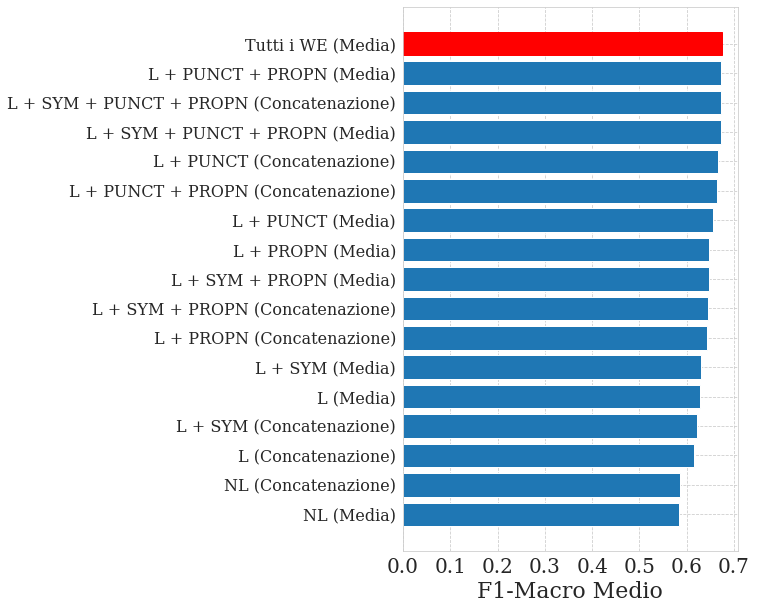

In [131]:
# visualizzo gli f1-macro medi di ciascuna aggregazione di WE 

sorted_data = sorted(results.items(), key=lambda x: x[1], reverse=False)
key, values = zip(*sorted_data)

plt.figure(figsize=(6, 10))
ax = plt.barh(key, values)
ax[16].set_color('red')

plt.xlabel('F1-Macro Medio', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(rotation=0)
plt.show()

### Classificazione binaria di irony

In [132]:
# estraggo le train features e le test features

train_features = extract_features(train_dataset, we, 32, aggregation='mean')
test_features = extract_features(test_dataset, we, 32, aggregation='mean')

In [133]:
# inizializzo X_train (con normalizzazione) e y_train

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features)
y_train = generate_y(train_files, 'irony')

In [134]:
# inizializzo X_test (con normalizzazione) e y_test

scaler = MinMaxScaler()
X_test = scaler.fit_transform(test_features)
y_test = generate_y(test_files, 'irony')

In [135]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3977, 32) (3977,)
(872, 32) (872,)


In [148]:
# effettuo randomized search su X_train, y_train

randomized_search_svm(X_train, y_train)

Best score: 0.6944908316495443, Best estimator: SVC(class_weight='balanced', gamma=1.0, max_iter=1000000.0)


In [150]:
# inizializzo e traino il best estimator

clf = SVC(C=1, gamma=1, kernel='rbf', class_weight='balanced', max_iter=1e6)
clf.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', gamma=1, max_iter=1000000.0)

In [152]:
# valuto il best estimator su train con 5-Fold CV

KFold_CV(5, clf, X_train, y_train)

{'Avg Accuracy Baseline': (0.5086760848266489, 0.018663369136801927),
 'Avg F1-Macro baseline': (0.3370654255475562, 0.008227033324035762),
 'Avg Accuracy Model': (0.698011440852059, 0.009148232441752282),
 'Avg F1-Macro Model': (0.6959150043769399, 0.00906978943894964)}

In [151]:
# valuto il best estimator su hold-out test

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.76      0.67       437
           1       0.67      0.48      0.56       435

    accuracy                           0.62       872
   macro avg       0.63      0.62      0.61       872
weighted avg       0.63      0.62      0.61       872



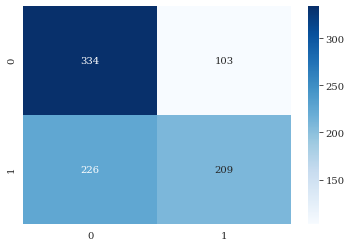

In [153]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

### Valutazione di diverse configurazioni di WE con K-Fold CV (TR) per irony_sarcasm

In [154]:
# inizializzo un dizionario che registra i risultati della K-Fold CV su TR

results = dict()

In [155]:
# calcolo la F1-Macro su K-Fold per la media di tutti i WE e di tutti i WE e aggiungo a results

train_features = extract_features(train_dataset, we, 32, aggregation='mean')

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features)
y_train = generate_y(train_files, 'irony_sarcasm')

clf = LinearSVC(dual=False, max_iter=1e4)
kfold_results = KFold_CV(5, clf, X_train, y_train)
avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
results['Tutti i WE (Media)'] = avg_f1_macro

In [156]:
# per ciascun candidato, uso la media come funzione di aggregazione, calcolo la F1-Macro su K-Fold e aggiungo a results

for candidate in candidates:
    
    train_features = extract_features(train_dataset, we, 32, aggregation='filtered_mean', pos_filter=candidates[candidate])
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_features)
    y_train = generate_y(train_files, 'irony_sarcasm')
    
    clf = LinearSVC(dual=False, max_iter=1e4)
    kfold_results = KFold_CV(5, clf, X_train, y_train)
    avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
    
    results[f'{candidate} (Media)'] = avg_f1_macro

In [157]:
# per ciascun candidato, uso la concatenazione di medie come funzione di aggregazione, calcolo la F1-Macro su K-Fold e aggiungo a results 

for candidate in candidates:
    
    train_features = extract_features(train_dataset, we, 32, aggregation='concatenated_means', pos_filter=candidates[candidate])
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_features)
    y_train = generate_y(train_files, 'irony_sarcasm')
    
    clf = LinearSVC(dual=False, max_iter=1e4)
    kfold_results = KFold_CV(5, clf, X_train, y_train)
    avg_f1_macro = kfold_results['Avg F1-Macro Model'][0]
    
    results[f'{candidate} (Concatenazione)'] = avg_f1_macro

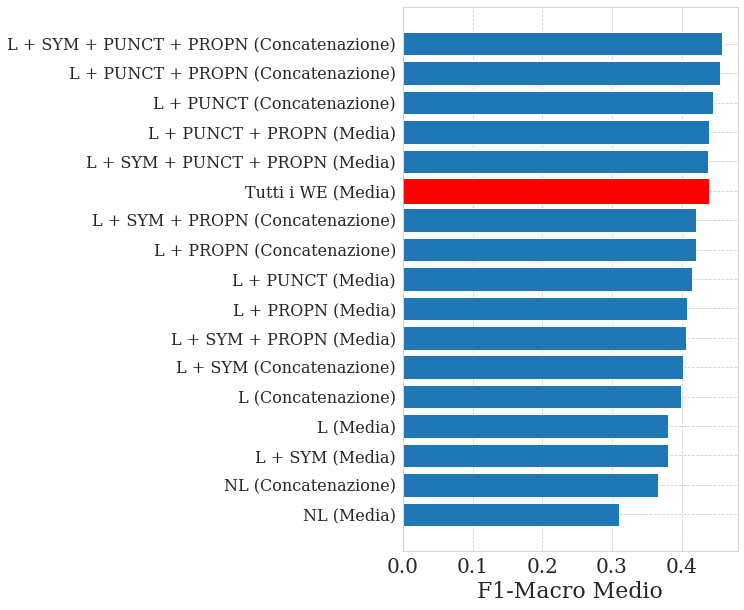

In [160]:
# visualizzo gli f1-macro medi di ciascuna aggregazione di WE 

sorted_data = sorted(results.items(), key=lambda x: x[1], reverse=False)
key, values = zip(*sorted_data)

plt.figure(figsize=(6, 10))
ax = plt.barh(key, values)
ax[11].set_color('red')

plt.xlabel('F1-Macro Medio', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(rotation=0)
plt.show()

### Classificazione multi-classe di irony_sarcasm

In [161]:
# estraggo le train features e le test features

pos_filter = ['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV', 'PUNCT', 'SYM']
train_features = extract_features(train_dataset, we, 32, aggregation='concatenated_means', pos_filter=pos_filter)
test_features = extract_features(test_dataset, we, 32, aggregation='concatenated_means', pos_filter=pos_filter)

In [162]:
# inizializzo X_train (con normalizzazione) e y_train

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features)
y_train = generate_y(train_files, 'irony_sarcasm')

In [163]:
# inizializzo X_test (con normalizzazione) e y_test

scaler = MinMaxScaler()
X_test = scaler.fit_transform(test_features)
y_test = generate_y(test_files, 'irony_sarcasm')

In [164]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3977, 224) (3977,)
(872, 224) (872,)


In [165]:
# effettuo randomized search su X_train, y_train

randomized_search_svm(X_train, y_train, scoring='f1_macro')

Best score: 0.4940180445565654, Best estimator: SVC(C=10.0, class_weight='balanced', gamma=0.01, kernel='poly',
    max_iter=1000000.0)


In [166]:
# inizializzo e traino il best estimator

clf = SVC(C=10, class_weight='balanced', kernel='poly', gamma=1e-2, max_iter=1e6)
clf.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma=0.01, kernel='poly',
    max_iter=1000000.0)

In [167]:
# valuto il best estimator su train con 5-Fold CV

KFold_CV(5, clf, X_train, y_train)

{'Avg Accuracy Baseline': (0.491323915173351, 0.018663369136801927),
 'Avg F1-Macro baseline': (0.21956676218045118, 0.0055787042809031274),
 'Avg Accuracy Model': (0.5247710249360007, 0.00804748728865843),
 'Avg F1-Macro Model': (0.495840276203351, 0.008661382968036653)}

In [168]:
# valuto il best estimator su hold-out test

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       437
           1       0.40      0.31      0.35       219
           2       0.43      0.46      0.44       216

    accuracy                           0.56       872
   macro avg       0.50      0.50      0.50       872
weighted avg       0.54      0.56      0.55       872



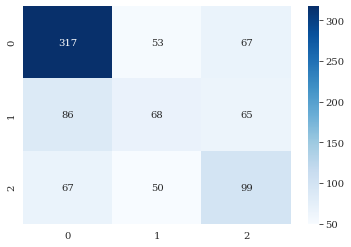

In [169]:
# visualizzo la matrice di confusione

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()